<a href="https://colab.research.google.com/github/yuntai/yuntai/blob/master/projects/bitgrit_shipping_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
running_in_colab = 'google.colab' in sys.modules

In [2]:
from pathlib import Path
if running_in_colab:
  from google.colab import drive
  drive.mount("/content/drive")
  rootdir = Path("/content/drive/My Drive/DATASETS/bitgrit/shipping_optimization_challenge")
else:
  rootdir = Path("/mnt/DATASETS/bitgrit/shipping_optimization_challenge")

Mounted at /content/drive


In [3]:
!pip install -U catboost
!pip install wget
!pip install xlrd
!pip install seaborn

     |████████████████████████████████| 66.2MB 45kB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=dd46abebdb5a4f919a599bdbf43b637fbc8f336084c3973798ef7e964e3d5222
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [6]:
ls "{rootdir}"

prep.py                           submission_2.csv  test_2.csv
README.md                         submission_3.csv  train_2_pr.csv
shipping_companies_details_1.csv  submission_4.csv  train_3_4_pr.csv


In [7]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import sklearn
import collections
from catboost import CatBoostClassifier
import seaborn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from catboost import CatBoostClassifier, Pool, cv
import re
import seaborn as sns

plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use('seaborn')

plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')


In [14]:
!head "{rootdir}/train_2_pr.csv"

,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61,355.0,0.75,Air,SC3,Y,5.00741
1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65,105.0,0.9,Ocean,SC1,Y,21.41215
2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22,100.0,0.75,Air,SC3,Y,5.33692
3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43,1071.0,1.05,Air,SC2,Y,5.14792
4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24,2007.0,0.75,Air,SC3,Y,5.03067
5,S001718,2019-05-27 11:53:23,A,Y,GB,IN,87.84,228.7,0.75,Air,SC3,Y,5.18611
6,S001720,2019-06-08 07:46:01,A,Y,GB,IN,89.0,119.0,0.75,Air,SC3,Y,5.2206
7,S001736,2019-10-04 14:26:08,A,Y,GB,IN,86.7,65.0,0.9,Ocean,SC1,Y,11.01481
8,S001737,2019-11-20 12:26:32,A,Y,GB,IN,92.31,114.0,0.75,Air,SC3,Y,5.33322


In [15]:
pd.read_csv?

In [16]:
train_df = pd.read_csv(rootdir/'train_2_pr.csv')
train_df.drop(train_df.columns[0], axis=1, inplace=True)

In [18]:
train_df

,shipment_id,send_timestamp,pick_up_point,drop_off_point,source_country,destination_country,freight_cost,gross_weight,shipment_charges,shipment_mode,shipping_company,selected,shipping_time
0,S000720,2019-06-08 07:17:51,A,Y,GB,IN,88.61000,355.00,0.7500,Air,SC3,Y,5.00741
1,S000725,2019-07-12 15:23:21,A,Y,GB,IN,85.65000,105.00,0.9000,Ocean,SC1,Y,21.41215
2,S000736,2019-10-04 14:23:29,A,Y,GB,IN,86.22000,100.00,0.7500,Air,SC3,Y,5.33692
3,S000738,2020-01-07 09:19:50,A,Y,GB,IN,94.43000,1071.00,1.0500,Air,SC2,Y,5.14792
4,S000739,2020-04-11 06:36:03,A,Y,GB,IN,94.24000,2007.00,0.7500,Air,SC3,Y,5.03067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,S7631147,2020-03-31 10:32:09,A,X,GB,BD,104.86000,304.00,1.1250,Ocean,SC1,Y,15.26933
5110,S9671147,2020-04-05 16:36:06,A,X,GB,BD,103.56125,240.00,0.5625,Ocean,SC2,Y,12.41192
5111,S1407148,2020-04-09 10:59:51,A,X,GB,BD,105.55000,400.00,1.1250,Ocean,SC1,Y,5.68333
5112,S7478148,2020-04-24 15:27:00,A,X,GB,BD,105.95000,398.00,1.1250,Ocean,SC1,Y,41.97199


Text(0.5, 1.0, 'freight_cost')

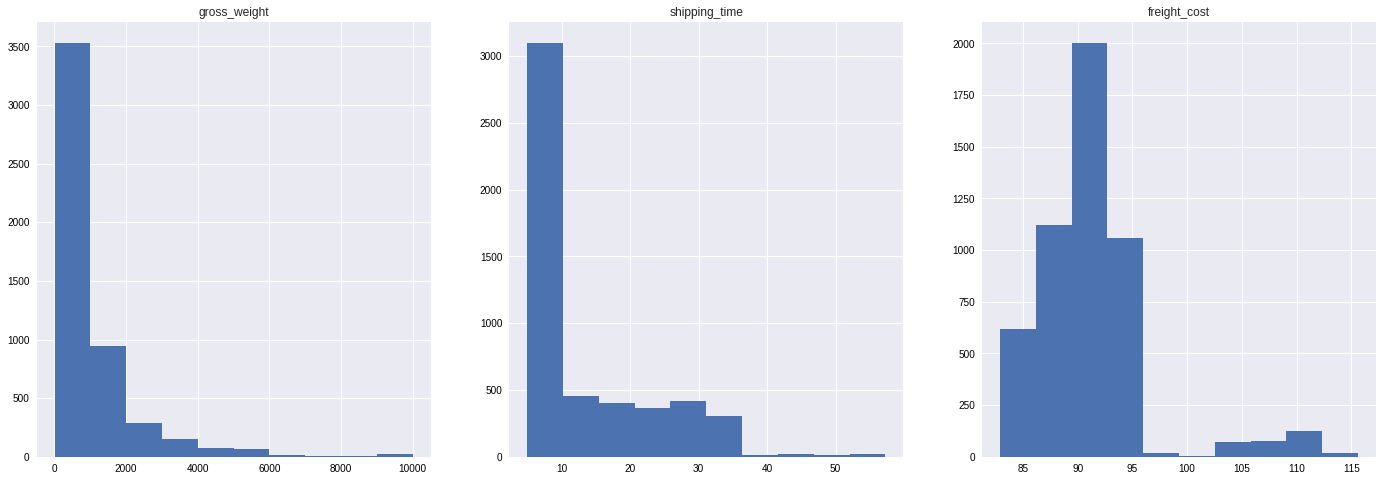

In [33]:
_, axes = plt.subplots(1, 3, figsize=(24, 8))
train_df.gross_weight.hist(ax=axes[0]).set_title('gross_weight');
train_df.shipping_time.hist(ax=axes[1]).set_title('shipping_time');
train_df.freight_cost.hist(ax=axes[2]).set_title('freight_cost');

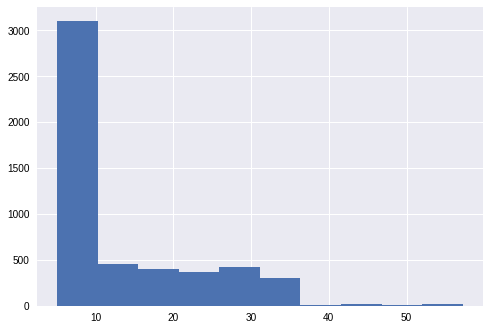

In [27]:
train_df.shipping_time.hist();

# Preprocessing

In [ ]:
import pandas as pd
import xlrd

mapping0 = {
  '아세톤':'A',
  '톨루엔':'T',
  '자일렌':'X',
  '아&자11':'AX11',
  '아&자13':'AX13',
  '아&자31':'AX31',
  '아&톨11':'AT11',
  '아&톨13':'AT13',
  '아&톨31':'AT31',
  '톨&자11':'TX11',
  '톨&자13':'TX13',
  '톨&자31':'TX31',
  '톨&자&아111':'TXA111'
}

sheets_mapping = {
  'Acetone':'A',
  'Toluene':'T',
  'Xylene':'X',
  'A&X 11':'AX11',
  'A&X 13':'AX13',
  'A&X 31':'AX31',
  'T&A 11':'AT11',
  'T&A 31':'AT13',
  'T&A 13':'AT31',
  'T&X 11':'TX11',
  'T&X 13':'TX13',
  'T&X 31':'TX31',
  'T&X&A 111': 'TXA111',
}

def read_sheet(name):
    df = pd.read_excel(GAS_FN, name)
    cols_to_drop = [c for c in df.columns if c.startswith('Unnamed:') or c.startswith('No..')]
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.rename(columns={'No.': 't'}, inplace=True)
    return df

def read_inout():
    df = pd.read_excel(GAS_INOUT_FN)
    df = df.iloc[:, 3:]
    df.rename(columns=mapping0, inplace=True)
    res = {}
    for c in df.columns:
        L = df[c].tolist()
        R = [L[i:i+3] for i in range(0,len(L)-1,2)]
        for r in R[:-1]:
            r[-1] -= 1
        assert len(R) == 10
        res[c] = R
    return res

channels = ['CH21','CH34','CH37','CH12','CH35','CH38','CH33','CH36','CH19']
channels = dict(enumerate(channels))
rchanmap = {i: k for i, k in channels.items()}

In [ ]:
w = xlrd.open_workbook(GAS_FN)
names = w.sheet_names()
sheets = {}
for n in tqdm(names):
  df = read_sheet(n)
  df.set_index('t', inplace=True)
  sheets[sheets_mapping[n]] = df

tm_df = read_inout()

gas_types = dict(enumerate(tm_df.keys()))
rgastypes = {v:k for k, v in gas_types.items()}

  8%|▊         | 1/13 [00:03<00:39,  3.32s/it]

In [ ]:
# normalization
sheets_norm = {}
ppm = np.concatenate([10./np.array([2,4,6,8,10])]*2, axis=-1)
for k in sorted(tm_df.keys()):
  tms = tm_df[k]
  df = sheets[k].copy()
  for (r0, _, r2), p in zip(tms, ppm):
    df.loc[r0:r2,:] = df.loc[r0:r2,:] * p
  sheets_norm[k] = df

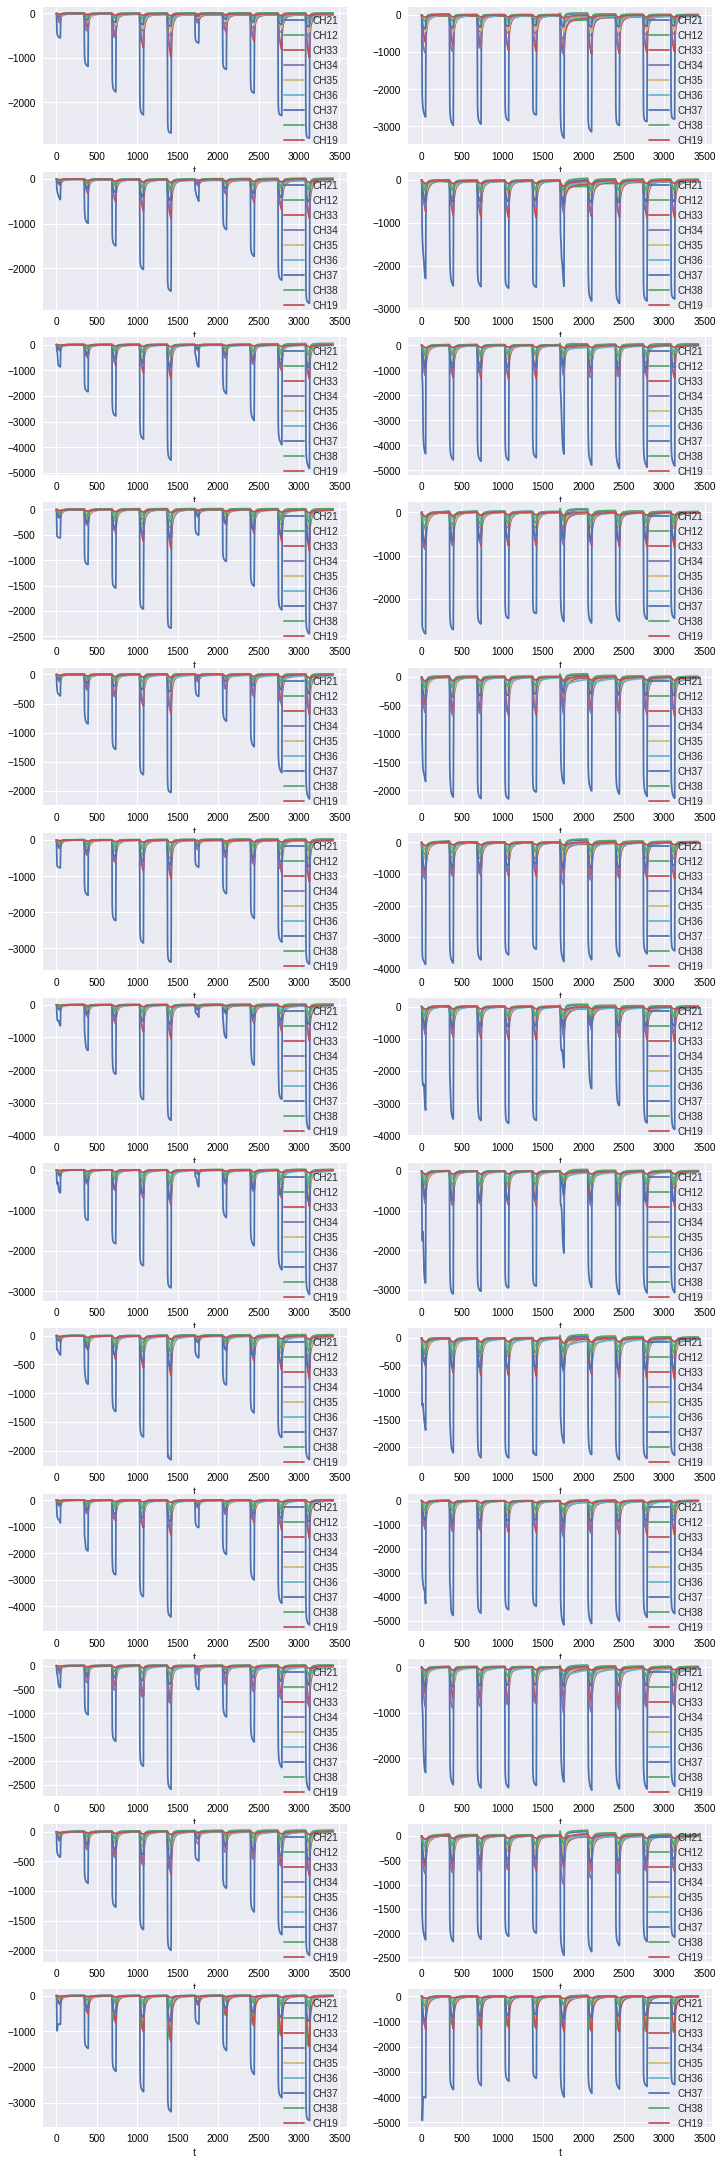

In [ ]:
# normalization result visualization
fig, axes = plt.subplots(len(sheets), 2, figsize=(12, 3*len(sheets)))
for i, k in enumerate(sheets):
  sheets[k].plot(ax=axes[i,0])
  sheets_norm[k].plot(ax=axes[i,1])

[1, 50, 342]


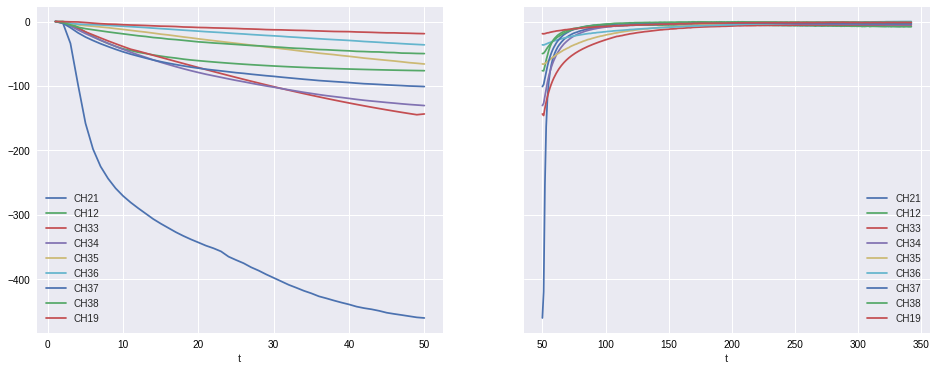

In [ ]:
r = tm_df['A'][0]
print(r)
_, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)
sheets['A'].loc[r[0]:r[1]].plot(ax=axes[0]);
sheets['A'].loc[r[1]:r[2]].plot(ax=axes[1]);

In [ ]:
def build_target_sheets():
  target_sheets = {}
  keys = sorted(tm_df.keys())
  #combo_keys = [k for k in keys if k!='TXA111']
  xs, ys = [], []
  for k in keys:
    print(f"processing target {k}...")
    tm = tm_df[k]
    df = pd.DataFrame(data=np.array(tm), columns=["x0", "x1", "x2"])
    df['target'] = k
    df['target_k'] = re.match(r'^[ATX]+', k).group()
    tp = re.search(r'\d\d', k)
    if tp:
      tp = tp.group()
    df['target_p'] = tp
    target_sheets[k] = df
  return target_sheets    

def build_exp_sheets(target_sheets):
  exp_sheets = {}
  for t in ["AT", "AX", "TX"]:
    print(f"bulding exp seet {t}")
    exp_sheets[t] = pd.concat([target_sheets[t+k] for k in ["11", "13", "31"]])
    exp_sheets[t] = pd.concat([exp_sheets[t]]+[target_sheets[s] for s in t])
  return exp_sheets    

def build_exp_sheets_all(target_sheets):
  exp_sheets = {}
  for t in ["AT", "AX", "TX"]:
    print(f"bulding exp seet {t}")
    exp_sheets[t] = pd.concat([target_sheets[t+k] for k in ["11", "13", "31"]])
    exp_sheets[t] = pd.concat([exp_sheets[t]]+[target_sheets[s] for s in t])
  return exp_sheets    
  
target_sheets = build_target_sheets()
exp_sheets = build_exp_sheets(target_sheets)
exp_sheets_all = pd.concat(target_sheets.values())

processing target A...
processing target AT11...
processing target AT13...
processing target AT31...
processing target AX11...
processing target AX13...
processing target AX31...
processing target T...
processing target TX11...
processing target TX13...
processing target TX31...
processing target TXA111...
processing target X...
bulding exp seet AT
bulding exp seet AX
bulding exp seet TX


In [ ]:
assert exp_sheets_all.shape[0] == 13 * 10 #  13 kinds * 10 experiments
assert all(v.shape[0]==5*10 for v in exp_sheets.values())

In [ ]:
print(exp_sheets.keys())
print(exp_sheets['AT'].head())
print(exp_sheets['AT'].target.unique())

dict_keys(['AT', 'AX', 'TX'])
     x0    x1    x2 target target_k target_p
0     1    50   342   AT11       AT       11
1   343   392   685   AT11       AT       11
2   686   735  1027   AT11       AT       11
3  1028  1076  1369   AT11       AT       11
4  1370  1419  1710   AT11       AT       11
['AT11' 'AT13' 'AT31' 'A' 'T']


In [ ]:
print(exp_sheets_all.target.unique())
exp_sheets_all.head()

['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'TXA111' 'X']


,x0,x1,x2,target,target_k,target_p
0,1,50,342,A,A,None
1,343,392,684,A,A,None
2,685,734,1027,A,A,None
3,1028,1077,1369,A,A,None
4,1370,1419,1710,A,A,None


## Building Features

In [ ]:
TC_props = np.arange(0.1, 1.0, 0.1)

def build_features(gas_sheets, df, th=0.1):
  cnt = 0
  exp_df = df.copy().reset_index(drop=True)
  features = collections.defaultdict(list)

  for _, row in exp_df.iterrows(): # one row corresponds to one experiment (one cycle of graph)
    gas_df = gas_sheets[row.target]
    num_sensors = gas_df.shape[1]

    features[f"mag_peak"].append(gas_df.loc[row.x1, :])
  
    # get constant time and corresponding magnitude value in **up** phases
    mag_up = gas_df.loc[row.x0:row.x1, :] - gas_df.loc[row.x0, :]
    mag_up_range = (gas_df.loc[row.x1,:] - gas_df.loc[row.x0, :]).abs()
    prop = mag_up.abs() / mag_up_range
    diff_up = mag_up.abs().diff(3)/3.

    for p in TC_props:
      tms, vals, diffs = [], [], []
      for k in range(num_sensors):
        s = prop.iloc[:,k]
        m = mag_up.iloc[:, k]
        d = diff_up.iloc[:, k]
        tm = s[s >= p].index[0]
        vals.append(m[tm])
        diffs.append(d[tm])
        tms.append(tm - row.x0)
      features[f'TC_up_{p:.1f}'].append(pd.Series(tms, index=gas_df.columns))
      features[f'mag_up_{p:.1f}'].append(pd.Series(vals, index=gas_df.columns))
      features[f'diff_up_{p:.1f}'].append(pd.Series(diffs, index=gas_df.columns))
  
    # get constant time and corresponding magnitude value in **down** phases
    mag_dn = gas_df.loc[row.x1:row.x2, :] - gas_df.loc[row.x1, :]
    prop = mag_dn.abs() / mag_dn.abs().iloc[-1,:]
    diff_dn = mag_dn.abs().diff(3)/3.
    for p in TC_props:
      tms, vals, diffs = [], [], []
      for k in range(num_sensors):
        s = prop.iloc[:,k]
        m = mag_dn.iloc[:, k]
        d = diff_dn.iloc[:, k]
        tm = s[s >= p].index[0]
        vals.append(m[tm])
        diffs.append(d[tm])
        tms.append(tm - row.x1)
      features[f'TC_dn_{p:.1f}'].append(pd.Series(tms, index=gas_df.columns))
      features[f'mag_dn_{p:.1f}'].append(pd.Series(vals, index=gas_df.columns))
      features[f'diff_dn_{p:.1f}'].append(pd.Series(diffs, index=gas_df.columns))

    recs = []
    for k in range(num_sensors):
      d = diff_dn.iloc[:, k]
      #TODO: change to bisect
      if d[d < th].shape[0] == 0:
        cnt += 1
        recs.append(row.x2 - row.x1)
      else:
        recs.append(d[d < th].index[0] - row.x1)
    features[f'T_rec'].append(pd.Series(recs, index=gas_df.columns))
  
    diff = gas_df.loc[row.x0:row.x2, :].diff(3).iloc[3:,:]/3.
    max_diff = diff.max()
    min_diff = diff.min()

    features['diff_at_peak'].append(diff.loc[row.x1+1,:])
    
    # cutting heading null since we are only calculating global var
    diff_up = gas_df.loc[row.x0:row.x1, :].diff(3).iloc[3:,:]/3 
    diff_dn = gas_df.loc[row.x1:row.x2, :].diff(3).iloc[3:,:]/3
    assert diff_up.isna().sum().sum() == 0
    assert diff_dn.isna().sum().sum() == 0

    max_diff_up = diff_up.max()
    min_diff_up = diff_up.min()
    max_diff_dn = diff_dn.max()
    min_diff_dn = diff_dn.min()
  
    features['max_diff'].append(max_diff) # max derivtive
    features['min_diff'].append(min_diff) # min derivative
    features['max_diff_up'].append(max_diff_up) # max derivative up
    features['min_diff_up'].append(min_diff_up) # min derivative down
    features['max_diff_dn'].append(max_diff_dn) # max dreivative up
    features['min_diff_dn'].append(min_diff_dn) # min derivative down
  
  # --------------------------------------------------------
  keys = sorted(features.keys())
  feats = {}
  for k in keys:
    ser = features[k]
    ser = pd.concat(ser, axis=1).transpose()
    ser.columns = [f'{k}_{c}' for c in ser.columns]
    ser.reset_index(drop=True, inplace=True)
    feats[k] = ser

  exp_df = pd.concat([exp_df]+list(feats.values()), axis=1)
  #print(cnt)
  return exp_df

In [ ]:
exp_dfs = {k: build_features(sheets_norm, exp_sheets[k]) for k in exp_sheets}
exp_df_all = build_features(sheets_norm, exp_sheets_all)

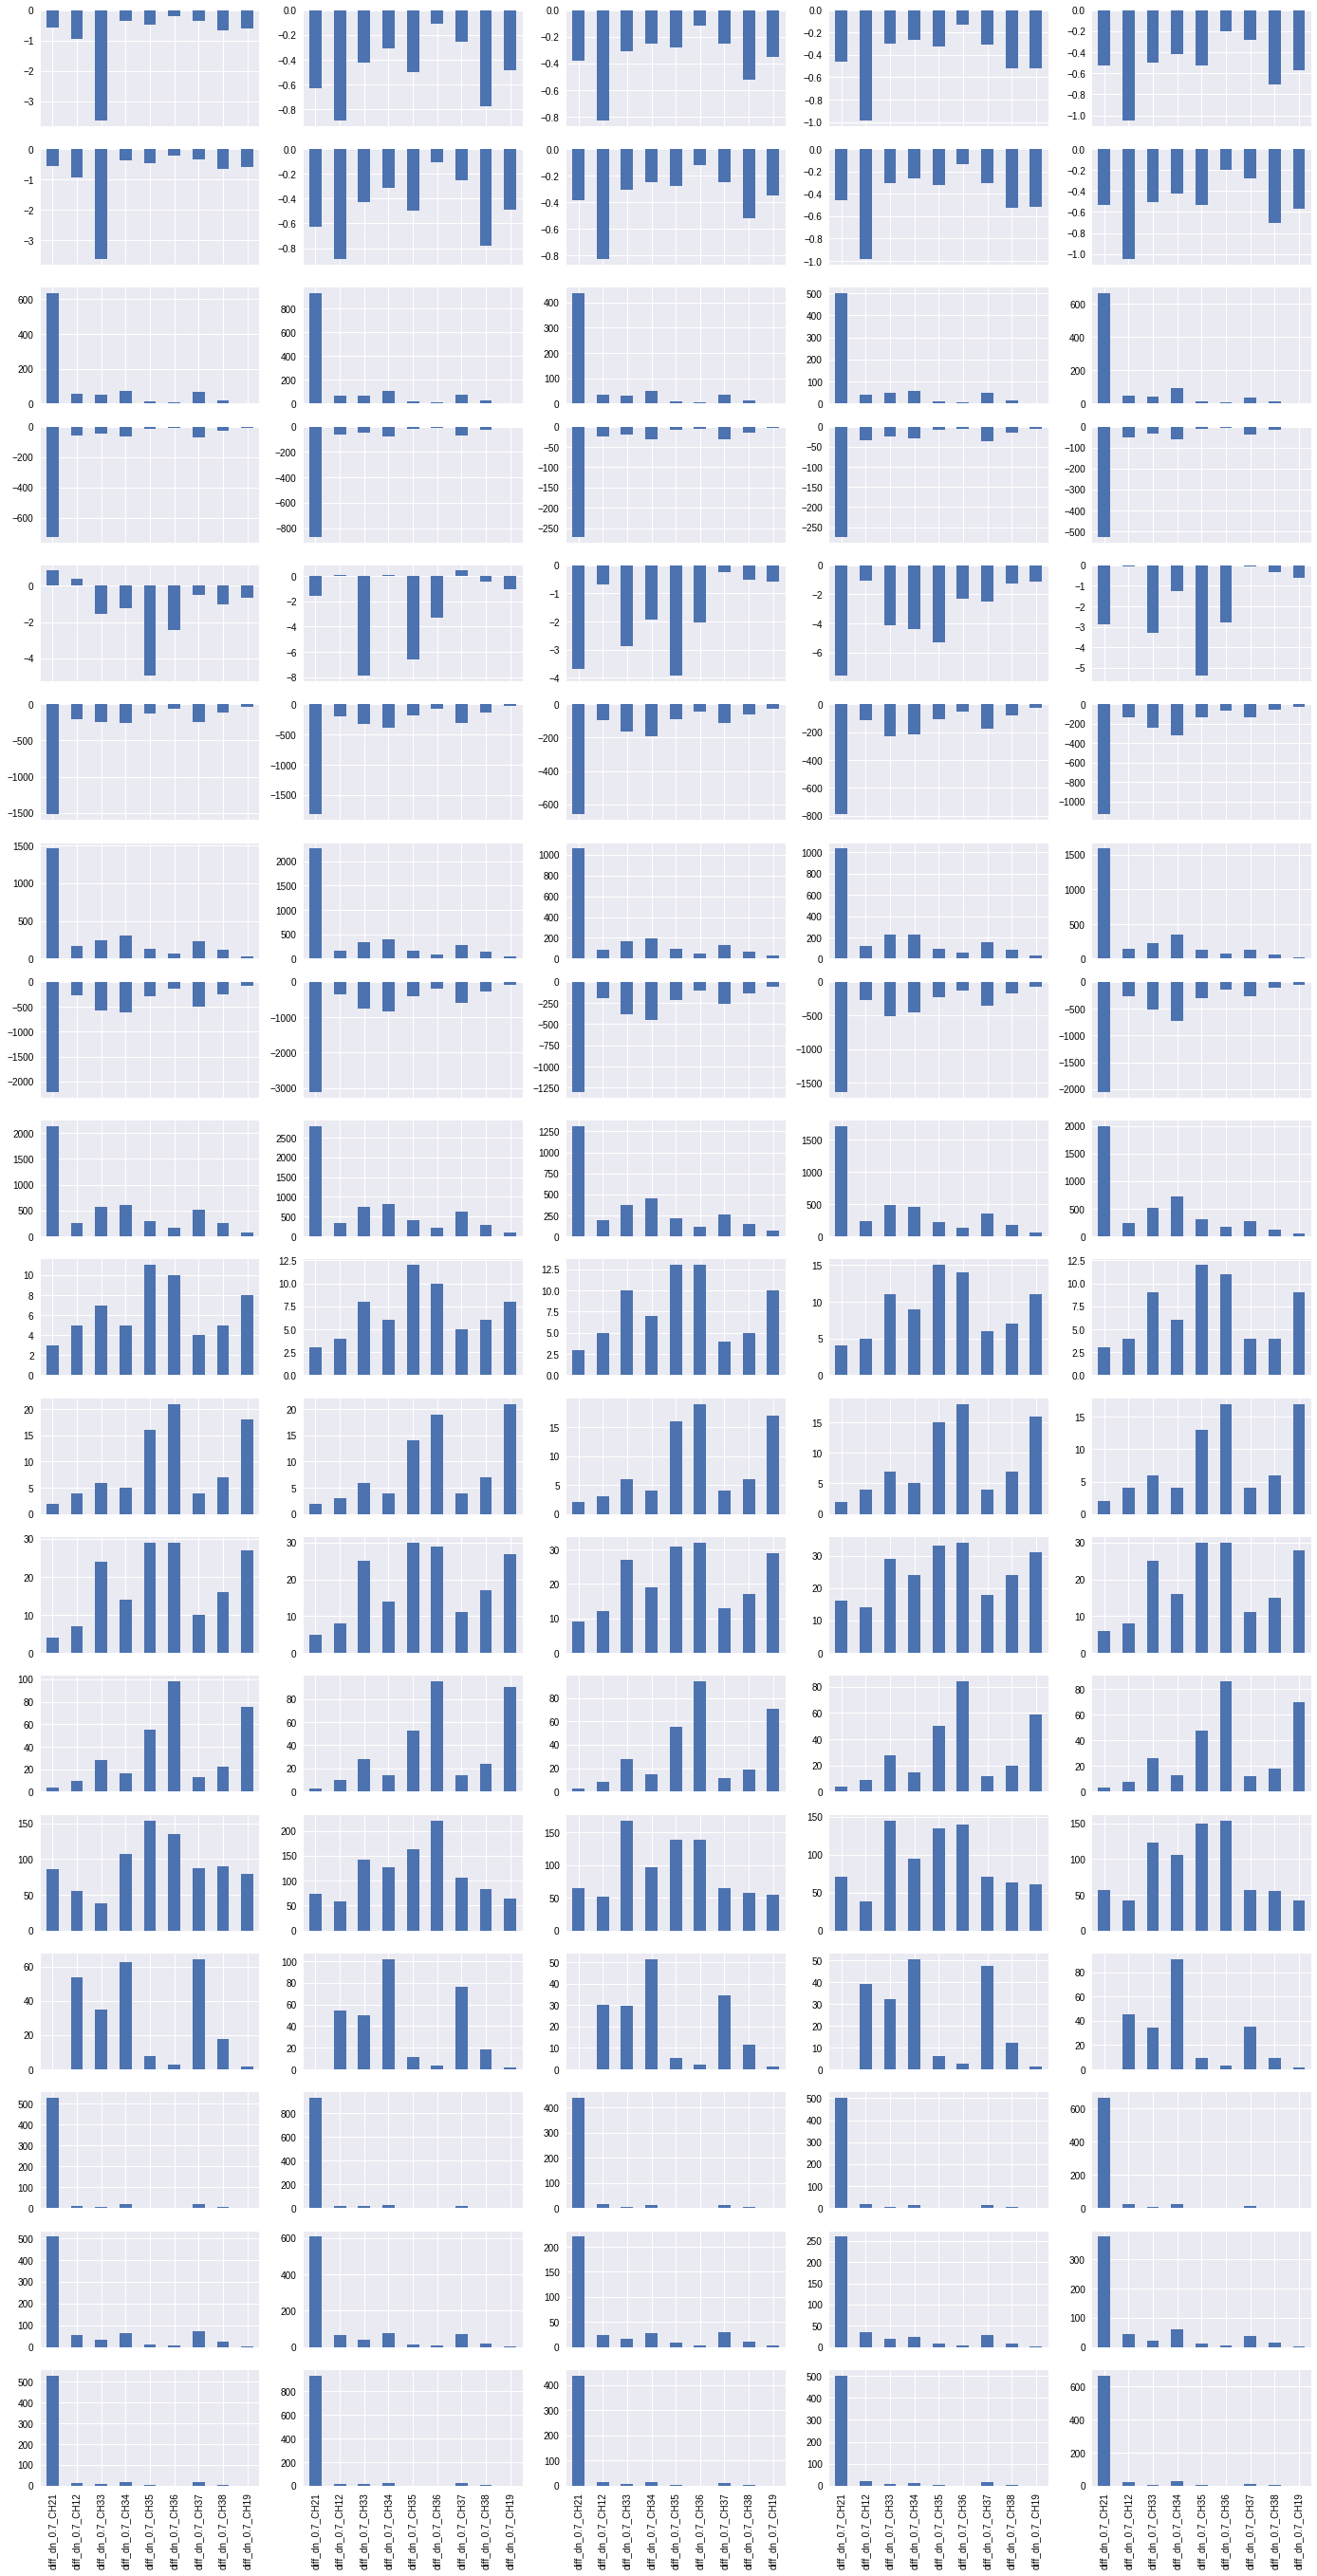

In [ ]:
x = exp_dfs['AT']
_, axes = plt.subplots(18,5, figsize=(24,48), sharex=True)
cols = ['min_diff_dn', 'min_diff_dn', 'max_diff_dn', 'min_diff_up', 'max_diff_up', 'mag_up_0.3', 'mag_dn_0.3', 'mag_up_0.7', 'mag_dn_0.7', 'TC_up_0.3',
  'TC_dn_0.3', 'TC_up_0.7', 'TC_dn_0.7', 'T_rec', 'diff_dn_0.3', 'diff_dn_0.7', 'diff_up_0.3', 'diff_dn_0.7']

def __plot(y, cn, jx, ix):
  y[[c for c in y.index if c.startswith(cn)]].plot(kind='bar', ax=axes[jx][ix])

for ix, t in enumerate(x.target.unique()):
  y = x.loc[x.target==t, :].iloc[0]
  for jx, cn in enumerate(cols):
    __plot(y, cn, jx, ix)


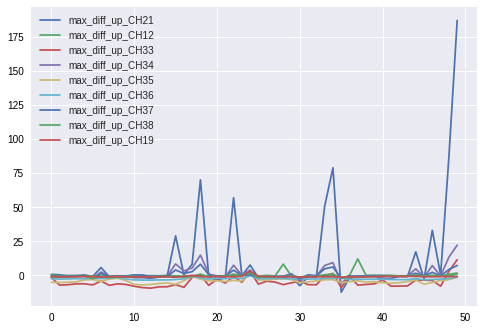

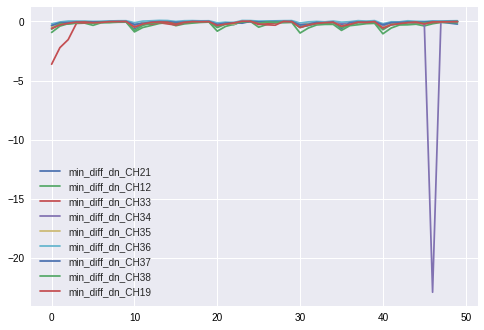

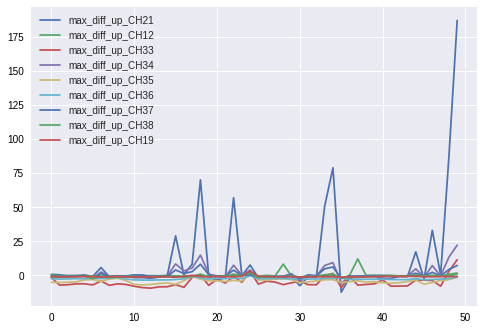

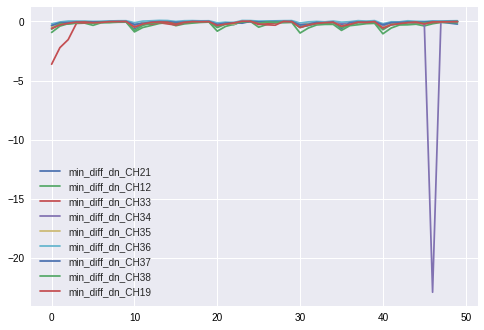

In [ ]:
x[[c for c in x.columns if c.startswith('max_diff_up')]].plot()
x[[c for c in x.columns if c.startswith('min_diff_dn')]].plot()
x[[c for c in x.columns if c.startswith('max_diff_up')]].plot()
x[[c for c in x.columns if c.startswith('min_diff_dn')]].plot()

In [ ]:
# features per channel
set(["_".join(c.split('_')[:-1]) for c in exp_dfs['AT'].columns if c not in ['x0', 'x1', 'x2'] and not c.startswith('target')])

{'TC_dn_0.1',
 'TC_dn_0.2',
 'TC_dn_0.3',
 'TC_dn_0.4',
 'TC_dn_0.5',
 'TC_dn_0.6',
 'TC_dn_0.7',
 'TC_dn_0.8',
 'TC_dn_0.9',
 'TC_up_0.1',
 'TC_up_0.2',
 'TC_up_0.3',
 'TC_up_0.4',
 'TC_up_0.5',
 'TC_up_0.6',
 'TC_up_0.7',
 'TC_up_0.8',
 'TC_up_0.9',
 'T_rec',
 'diff_at_peak',
 'diff_dn_0.1',
 'diff_dn_0.2',
 'diff_dn_0.3',
 'diff_dn_0.4',
 'diff_dn_0.5',
 'diff_dn_0.6',
 'diff_dn_0.7',
 'diff_dn_0.8',
 'diff_dn_0.9',
 'diff_up_0.1',
 'diff_up_0.2',
 'diff_up_0.3',
 'diff_up_0.4',
 'diff_up_0.5',
 'diff_up_0.6',
 'diff_up_0.7',
 'diff_up_0.8',
 'diff_up_0.9',
 'mag_dn_0.1',
 'mag_dn_0.2',
 'mag_dn_0.3',
 'mag_dn_0.4',
 'mag_dn_0.5',
 'mag_dn_0.6',
 'mag_dn_0.7',
 'mag_dn_0.8',
 'mag_dn_0.9',
 'mag_peak',
 'mag_up_0.1',
 'mag_up_0.2',
 'mag_up_0.3',
 'mag_up_0.4',
 'mag_up_0.5',
 'mag_up_0.6',
 'mag_up_0.7',
 'mag_up_0.8',
 'mag_up_0.9',
 'max_diff',
 'max_diff_dn',
 'max_diff_up',
 'min_diff',
 'min_diff_dn',
 'min_diff_up'}

In [ ]:
def cv_run(exp_df, target_sz=5, target_column='target'):
  exp_df = exp_df.sample(frac=1.) # shuffle
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
  cv_params = model.get_params()
  cv_params.update({
    'loss_function': 'MultiClass'
  })
  cv_data = cv(
    Pool(X, label=y),
    cv_params,
    plot=False,
    verbose=False,
    stratified=True
  )
  ix = np.argmax(cv_data['test-Accuracy-mean'])
  mean = np.max(cv_data['test-Accuracy-mean'])
  std = cv_data['test-Accuracy-std'][ix]
  print(f"mean({mean:.2f}) ±{std:.2f}")
  model.eval_metrics(cv_data, ['Precision'])

In [ ]:
from catboost.utils import get_confusion_matrix
def fit_cv_run(exp_df, test_sz=0, target_column='target'):
  exp_df = exp_df.sample(frac=1.)
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  num_classes = y.nunique()
  cm = np.zeros((num_classes, num_classes))
  skf = StratifiedKFold(n_splits=3, shuffle=False)
  accs, losses = [], []
  for train_index, val_index in skf.split(X, y):
    X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
    model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
    model.fit(X_train, y_train, eval_set=(X_validation, y_validation), verbose=False) # fit 
    score = model.get_best_score()
    #print("score=", score)
    acc = score['validation']['Accuracy']
    loss = score['validation']['MultiClass']
    accs.append(acc)
    losses.append(loss)
    cm += np.array(get_confusion_matrix(model, Pool(X_validation, y_validation)))
  accs = np.array(accs)    
  losses = np.array(losses)    
  return cm/cm.sum(axis=-1), accs.mean(), accs.std(), losses.mean(), losses.std(), model.classes_

'AT' cv run
['A' 'AT11' 'AT13' 'AT31' 'T']
[[1.  0.  0.  0.  0. ]
 [0.  0.9 0.1 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]
accuracy mean: 0.9792±0.0295
loss mean: 0.1408±0.0357
'AX' cv run
['A' 'AX11' 'AX13' 'AX31' 'X']
[[0.8 0.  0.  0.2 0. ]
 [0.1 0.9 0.  0.  0. ]
 [0.  0.  0.9 0.1 0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  1. ]]
accuracy mean: 0.9387±0.0511
loss mean: 0.2463±0.0853
'TX' cv run
['T' 'TX11' 'TX13' 'TX31' 'X']
[[1.  0.  0.  0.  0. ]
 [0.  0.9 0.  0.  0.1]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.4 0.  0.  0.6]]
accuracy mean: 0.9203±0.0731
loss mean: 0.3669±0.1436


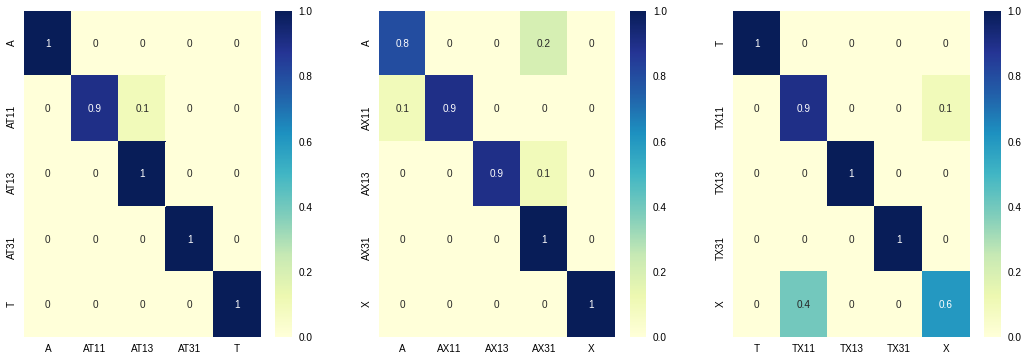

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, k in enumerate(exp_dfs):
  print(f"'{k}' cv run")
  cm, acc_mean, acc_std, loss_mean, loss_std, classes = fit_cv_run(exp_dfs[k])
  print(classes)
  print(cm)
  print(f"accuracy mean: {acc_mean:.4f}±{acc_std:.4f}")
  print(f"loss mean: {loss_mean:.4f}±{loss_std:.4f}")
  sns.heatmap(cm, cmap="YlGnBu", annot=True, xticklabels=classes, yticklabels=classes, ax=axes[i]);

['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'TXA111' 'X']
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.8 0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.9 0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]
accuracy mean: 0.954±0.018
loss mean: 0.228±0.034


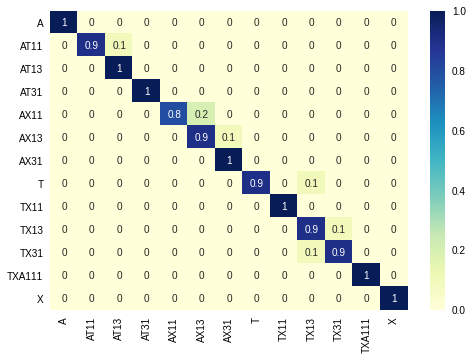

In [ ]:
cm, acc_mean, acc_std, loss_mean, loss_std, classes = fit_cv_run(exp_df_all)
print(classes)
print(cm)
print(f"accuracy mean: {acc_mean:.3f}±{acc_std:.3f}")
print(f"loss mean: {loss_mean:.3f}±{loss_std:.3f}")
sns.heatmap(cm, cmap="YlGnBu", annot=True, xticklabels=classes, yticklabels=classes)

In [ ]:
def fit_run(exp_df, test_sz=0, target_column='target'):
  exp_df = exp_df.sample(frac=1.)
  
  X = exp_df.drop(['x0', 'x1', 'x2', 'target', 'target_k', 'target_p'], axis=1)
  y = exp_df[target_column]

  if test_sz > 0:
    X_test = X.iloc[-test_sz:,:]  
    y_test = np.array(y.iloc[-test_sz:])
    print(X_test.shape, end=" ")
  
    X = X.iloc[:-test_sz,:]
    y = y[:-test_sz]
  
  X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, stratify=y)
  print(X_train.shape, end=" ")
  print(X_validation.shape, end= " ")
  
  model = CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU")
  model.fit(X_train, y_train, eval_set=(X_validation, y_validation), verbose=False) # fit 
  print(model.classes_)
  
  if test_sz > 0: 
    pred = model.predict(X_test) # predict
    pred = np.squeeze(pred)
    #pred_proba = model.predict_proba(X_test) # predict prob
    print("predicted=", pred)
    print(" expected=", y_test)
    print(" test accuracy=", (pred==y_test).sum()/test_sz)

  print(model.get_best_score())
  print(model.get_feature_importance(prettified=True)[:10])

In [ ]:
for k in exp_dfs:
  print(f"'{k}' cv run")
  cv_run(exp_dfs[k])

'AT' cv run
mean(0.98) ±0.04
'AX' cv run
mean(0.96) ±0.08
'TX' cv run
mean(0.91) ±0.05


In [ ]:
print("cv run all")
cv_run(exp_df_all)

cv run all
mean(0.90) ±0.05


In [ ]:
# cv run w/o TXA111
cv_run(exp_df_all[exp_df_all.target != 'TXA111'])

mean(0.91) ±0.04


In [ ]:
for k in exp_dfs:
  print(f"'{k}' fit run")
  fit_run(exp_dfs[k])

'AT' fit run
(45, 567) (5, 567) ['A' 'AT11' 'AT13' 'AT31' 'T']
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.0075924654801686605}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.1347895860671997}}
         Feature Id  Importances
0   mag_dn_0.3_CH38     5.935235
1     mag_peak_CH12     4.439842
2   mag_up_0.6_CH37     4.024608
3   mag_dn_0.7_CH38     4.006894
4   mag_dn_0.9_CH36     3.531511
5  diff_up_0.2_CH38     3.392066
6  diff_up_0.4_CH36     3.278899
7     mag_peak_CH37     3.078444
8   mag_dn_0.9_CH38     2.999008
9  diff_up_0.6_CH34     2.683969
'AX' fit run
(45, 567) (5, 567) ['A' 'AX11' 'AX13' 'AX31' 'X']
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.009726126988728842}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.020742513239383698}}
         Feature Id  Importances
0  diff_dn_0.9_CH35     3.608610
1   mag_up_0.7_CH37     3.085340
2     mag_peak_CH12     3.048779
3   mag_up_0.6_CH36     3.003696
4   mag_dn_0.9_CH38     2.925738
5   mag_dn_0.7_CH37     2.700536
6  diff_up_0.

In [ ]:
fit_run(exp_df_all[exp_df_all.target != 'TXA111'])

(108, 567) (12, 567) ['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'X']
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.013401412301593356}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.18831928571065268}}
         Feature Id  Importances
0     mag_peak_CH12     7.126019
1  diff_up_0.9_CH36     3.755666
2  diff_up_0.9_CH33     3.270808
3   mag_up_0.9_CH37     2.956906
4   mag_up_0.8_CH12     2.409520
5   mag_dn_0.9_CH12     2.396800
6   mag_up_0.4_CH37     2.272792
7   mag_up_0.6_CH35     2.060169
8  diff_dn_0.4_CH38     1.945814
9   mag_up_0.6_CH37     1.612082


In [ ]:
fit_run(exp_df_all)

(117, 567) (13, 567) ['A' 'AT11' 'AT13' 'AT31' 'AX11' 'AX13' 'AX31' 'T' 'TX11' 'TX13' 'TX31'
 'TXA111' 'X']
{'learn': {'Accuracy': 1.0, 'MultiClass': 0.01442661244645078}, 'validation': {'Accuracy': 1.0, 'MultiClass': 0.15220077221210188}}
         Feature Id  Importances
0     mag_peak_CH12     5.391936
1   mag_up_0.8_CH12     3.318897
2  diff_up_0.9_CH36     3.042231
3  diff_up_0.7_CH36     2.747468
4   mag_up_0.9_CH37     2.343870
5   mag_up_0.8_CH37     2.149927
6  diff_up_0.6_CH36     2.060981
7  diff_dn_0.8_CH35     1.941015
8   mag_up_0.4_CH37     1.547398
9     mag_peak_CH19     1.465288


In [ ]:
# multi-label encoding
for t in "ATX":
  exp_df_all[f'target_{t}'] = exp_df_all.target.str.contains(t).astype('int')

In [ ]:
exp_df_all.loc[:, 'target_A':'target_X']

,target_A,target_T,target_X
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
125,0,0,1
126,0,0,1
127,0,0,1
128,0,0,1


In [ ]:
# multi-label fit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold

def multi_label_cv_run(exp_df, test_sz=0):
  exp_df = exp_df.sample(frac=1.)
  X = exp_df.drop([c for c in exp_df.columns if c.startswith('target')] + ["x0", "x1", "x2"], axis=1)
  y = exp_df.target
  y_hot = exp_df[["target_A", "target_T", "target_X"]]

  if test_sz > 0:
    X_test = X.iloc[-test_sz:,:]  
    y_test = np.array(y.iloc[-test_sz:])
    print(X_test.shape, end=" ")
  
    X = X.iloc[:-test_sz,:]
    y = y[:-test_sz]

  models, scores = [], []
  skf = StratifiedKFold(shuffle=True)
  for train_index, val_index in skf.split(X, y):
    X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[val_index], y_hot.iloc[train_index], y_hot.iloc[val_index]
    #TODO: how to use val set in fitting?
    ovr = OneVsRestClassifier(estimator=CatBoostClassifier(custom_loss=['Accuracy'], task_type="GPU"))
    ovr.fit(X_train, y_train)
    score = ovr.score(X_validation, y_validation)
    print("score=", score)
    scores.append(score)
    models.append(ovr)

  print("mean val score=", np.array(scores).mean(), "std=", np.array(scores).std()) 

  #TODO: k-hot decoding
  #TODO: accuracy calculation/meaning
  if test_sz > 0: 
    pred = ovr.predict(X_test) # predict
    pred = np.squeeze(pred)
    #pred_proba = model.predict_proba(X_test) # predict prob
    print("predicted=\n", pred)
    print("expected=\n", y_test)
    print("test accuracy=", (pred==y_test).sum()/test_sz/3)

#TODO: multilabel regression

In [ ]:
multi_label_cv_run(exp_df_all, test_sz=0)

Streaming output truncated to the last 5000 lines.
8:	learn: 0.4510047	total: 388ms	remaining: 42.7s
9:	learn: 0.4306740	total: 429ms	remaining: 42.5s
10:	learn: 0.4199904	total: 475ms	remaining: 42.7s
11:	learn: 0.4028787	total: 516ms	remaining: 42.5s
12:	learn: 0.3852930	total: 556ms	remaining: 42.2s
13:	learn: 0.3687940	total: 596ms	remaining: 42s
14:	learn: 0.3526419	total: 643ms	remaining: 42.2s
15:	learn: 0.3371911	total: 695ms	remaining: 42.7s
16:	learn: 0.3251990	total: 737ms	remaining: 42.6s
17:	learn: 0.3141498	total: 777ms	remaining: 42.4s
18:	learn: 0.3044569	total: 819ms	remaining: 42.3s
19:	learn: 0.2958388	total: 861ms	remaining: 42.2s
20:	learn: 0.2871912	total: 921ms	remaining: 42.9s
21:	learn: 0.2832175	total: 962ms	remaining: 42.8s
22:	learn: 0.2705260	total: 1s	remaining: 42.6s
23:	learn: 0.2612449	total: 1.04s	remaining: 42.4s
24:	learn: 0.2539020	total: 1.08s	remaining: 42.2s
25:	learn: 0.2487543	total: 1.14s	remaining: 42.5s
26:	learn: 0.2418635	total: 1.18s	rema